# Problema: Transferencia de Calor - Conducción en pared 1D

$\theta$ + $N^2$ G ( 1 + $\epsilon_G$ $\theta$ ) = 0

siendo

- $\theta(x) = \dfrac{T(x) - T_{inf}}{T_{b} - T_{inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_{inf})}$


- $\epsilon_G=\epsilon(T_b-T_{inf})$


- $\epsilon_C=\beta(T_b-T_{inf})$

condiciones de borde

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$

### Cargo Librerias

In [ ]:
# Monta carpetas de drive
from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

# Cargando Requirements
#!pip install -r "/content/drive/MyDrive/Taller PINNs/Clase_3/requirements.txt"
# Librerias utiles

# Importo libreriras
import os

import torch
import imageio
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch import tensor
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import time
from IPython.display import clear_output # lo usamos para que el gráfico se refresque y no te llene la pantalla de miles de gráficos.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Datos y parámetros del problema

In [ ]:
eg = .6
ec = .4
N = 1

In [ ]:
## Inicializo la semilla
random_seed =  1234 # Semilla fija (1234) que se utiliza para controlar la aleatoriedad.
torch.manual_seed(random_seed) # Inicia la semilla que afecta selección de pesos de la red.
                               # Resultados de torch.rand, torch.randn, etc.
                               # Orden aleatorio en datasets con DataLoader(..., shuffle=True).

## Cargo datos de simulación
relative_csv_path = "/content/drive/MyDrive/Taller PINNs/Clase_3/heat_transfer_finn.csv"
split_ratio = 0.2

# Cargo diferentes muestras de temperatura
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields_G = ['G']
fields = fields_T + fields_G

# cargo un perfil de temperaturas y G aleatorio
df = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
random_sample = df.sample()
print('Datos usados de la muestra disponible:', random_sample.index[0])

# === Variables físicas y espaciales ===
G_real = torch.tensor(random_sample[fields_G].to_numpy(), dtype=torch.float32)
T_real = random_sample[fields_T].to_numpy().reshape(-1, 1).astype(np.float32)
print('G real es:', G_real, 'Perfil T real es:', T_real)

# Posiciones espaciales donde dispongo información
X_real = np.linspace(0, 1, T_real.shape[0]).reshape(-1, 1).astype(np.float32)
# Punto de frontera derecha
X_bc = X_real[-1].reshape(1, 1)

# Cálculo temperatura adimensional
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_real = np.multiply(np.add(T_real, [-T_inf]), [1/(T_b - T_inf)])

# Bordes físicos
lb = min(X_real)
ub = max(X_real)

# Puntos de colocación
N_f = 100;
offset = 0.01
X_train_f = np.linspace(lb[0] + offset, ub[0] - offset, N_f).reshape(-1,1)

Datos usados de la muestra disponible: 335
G real es: tensor([[0.7542]]) Perfil T real es: [[400.     ]
 [401.6449 ]
 [403.04382]
 [404.2097 ]
 [405.15158]
 [405.87683]
 [406.391  ]
 [406.6979 ]
 [406.79996]]


### Funciones de normalización

### $\overline{\theta[i,j]}=2\frac{\theta[i,j]-\min(\theta[:, j]) }{\max(\theta[:,j]) - \min(\theta[:,j]) } - 1$

In [ ]:
def normalize_ij(xi, xmin, xmax):
    "Function to normalize a value xi given xmax and xmin boundaries"
    return 2 * (xi - xmin) / (xmax - xmin) - 1

def normalize(X_array, min_X_cols, max_X_cols):
    """
    Normalize an array by columns given a max and min of each column.

    Parameters:
    X_array(numpy array): Array to be normalized.
    """
    # Normalize input vector X by each feature
    (num_row_X, num_col_X) = X_array.shape
    normalized_X_array = np.zeros_like(X_array)

    # Fill the copy vector
    for col in range(num_col_X):
      for row in range(num_row_X):
        normalized_X_array[row,col] = normalize_ij(X_array[row,col], min_X_cols[col], max_X_cols[col])

    return normalized_X_array

def max_min_by_columns(X_array):
    # Compute the min max vector
    (num_row_X, num_col_X) = X_array.shape
    min_col_X = [np.min(X_array[:,col_X]) for col_X in range(num_col_X)]
    max_col_X = [np.max(X_array[:,col_X]) for col_X in range(num_col_X)]
    return min_col_X, max_col_X

## Preparo datos para entrenamiento de la red

In [ ]:
# Genero los tensores para entrenamiento
X_train_f = torch.tensor(X_train_f, dtype=torch.float32)
print("Puntos de colocación para entrenamiento", N_f)

X_bc = torch.tensor(X_bc, dtype=torch.float32)
X_real = torch.tensor(X_real, dtype=torch.float32)
Theta_real = torch.tensor(Theta_real, dtype=torch.float32)

print("Información de entrenamiento:")
print("Theta real tiene tamaño", Theta_real.shape)
print("X entrenamiento física tiene tamaño", X_train_f.shape)
print("X real tiene tamaño", X_real.shape)
print("BC tiene tamaño", X_bc.shape)

Puntos de colocación para entrenamiento 100
Información de entrenamiento:
Theta real tiene tamaño torch.Size([9, 1])
X entrenamiento física tiene tamaño torch.Size([100, 1])
X real tiene tamaño torch.Size([9, 1])
BC tiene tamaño torch.Size([1, 1])


## Creo la FFNN

In [ ]:
class DNN(nn.Module):
    def __init__(self, layers, activation_fn=None):
        """
        Fully-connected feedforward neural network.

        Parameters:
            layers (list): List of layer sizes [input_dim, ..., output_dim].
            activation_fn (nn.Module): Activation function (default: Tanh).
        """
        super(DNN, self).__init__()

        if activation_fn is None:
            self.activation_fn = nn.Tanh()
        else:
            self.activation_fn = activation_fn


        self.linears = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)
        ])

        # Xavier initialization
        for layer in self.linears:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x):
        for layer in self.linears[:-1]:
            x = self.activation_fn(layer(x))
        return self.linears[-1](x)

## Modelo PINN

In [ ]:
class PINN_finn(nn.Module):
    def __init__(self, layers, activation_fn, G_init):
        super(PINN_finn, self).__init__()
        """
        Build, train, and test a neural network model.
        """
        'Initialize iterator'
        self.iter = 0

        # Build model
        self.model = DNN(layers, activation_fn=activation_fn)
        self.loss_fn = nn.MSELoss(reduction='mean')
        self.loss_history = {"Total": []}

        'Inicializo nuevos parámetros G, N, ec, eg as como tensores (Problema inverso)'
        self.G = torch.tensor([float(G_init)], requires_grad=True)
        'Defino parámetros a optimizar en la red'
        self.G = nn.Parameter(self.G)

        'History of losses'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "G": [],
                             "Total":[]}

        'Parameters trials'
        self.params_history = {"G": [] }

    def forward(self, X):
        return self.model(X)

    def loss_data(self, X_train, y_train, save=False):
        y_pred = self.forward(X_train)
        loss_data = self.loss_fn(y_pred, y_train)
        if save:
            self.loss_history["Data"].append(loss_data.item())
        return loss_data

    def residual(self, x_f, save = False):

        # Separo parámetro de aprendizaje de la PDE
        G = self.G

        # Defino sobre que variable voy a derivar
        x = x_f.clone()
        x.requires_grad = True

        # Estimo theta
        theta = self.model(x)

        # Calculo derivada
        theta_x = autograd.grad(theta, x, torch.ones([x_f.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # Estimo termino a derivar
        aux = (( 1 + ec*theta ) * theta_x)
        # Derivo termino de la PDE
        aux_x = autograd.grad(aux, x, torch.ones([x_f.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # PDE res  = 0
        res = aux_x - ( N**2 )*theta + (N**2)*G*(1 + eg*theta)
        return res

    def loss_physics(self, X_phys, save=False):
        f = self.residual(X_phys)
        loss_f = self.loss_fn(f, torch.zeros_like(f))
        if save: self.loss_history["PDE"].append(loss_f.item())
        return loss_f

    def loss_BC(self, X_bc, save=False):
        # clone the input data and add AD
        x = X_bc.clone()
        x.requires_grad = True

        # predict theta
        theta = self.model(x)

        # compute derivatives
        theta_x = autograd.grad(theta, x, torch.ones([X_bc.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        loss_bc = self.loss_fn(theta_x, torch.zeros_like(theta_x))
        if save: self.loss_history["BC"].append(loss_bc.item())
        return loss_bc

    def loss_G(self, save=False):
        """
        Penaliza valores pequeños de G con una función diferenciable.
        """
        K = 1000.0  # Coeficiente de penalización
        # Penalización solo si G < 1e-5, suavemente (diferenciable)
        lossG = K * torch.relu(1e-5 - self.G)**2

        if save:
            self.loss_history["G"].append(lossG.item())

        return lossG

    def loss(self, x_real, theta_real, x_f, x_bc, save = False):
        loss_d  = self.loss_data(x_real, theta_real, save)
        loss_f  = self.loss_physics(x_f, save)
        loss_bc = self.loss_BC(x_bc, save)
        loss_g = self.loss_G(save)

        # weights should sum 1
        loss_total = loss_d + loss_f + loss_bc + loss_g

        if save:
          self.loss_history["Total"].append(loss_total.detach().cpu().numpy())
          self.params_history["G"].append(self.G.detach().cpu().numpy().copy())

        return loss_total

## Funciones de creación de imágenes

In [ ]:
def plot_loss_history(model):
    if len(model.loss_history['Total']) == 0:
        print('No hay pérdidas todavía')
        return  # No hay datos todavía, no grafiques

    epochs = range(len(model.loss_history['Total']))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, model.loss_history['Total'], label='Total Loss')
    if len(model.loss_history['Data']) == len(epochs):
        plt.plot(epochs, model.loss_history['Data'], label='Data Loss')
    if len(model.loss_history['PDE']) == len(epochs):
        plt.plot(epochs, model.loss_history['PDE'], label='Physics Loss')
    if len(model.loss_history['BC']) == len(epochs):
        plt.plot(epochs, model.loss_history['BC'], label='Boundary Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.title('Training Loss Evolution')
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)

## Parámetros de entrenamiento

In [ ]:
n_iter_adam = 10000
n_iter_LBFGS = 5000
learning_rate_adam = 5e-4
learning_rate_LBFGS = 1e-4
nneurons =32
nhiden_layers = 8
activation_fn = nn.Tanh()
input_dim = X_real.shape[1]
output_dim =  Theta_real.shape[1]
layers_finn = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])

print("[INFO] Estructura de la red PINN:")
print(f"  - Capa de entrada: {input_dim} nodos")
print(f"  - Capas ocultas: {nhiden_layers} capas de {nneurons} neuronas cada una")
print(f"  - Capa de salida: {output_dim} nodos")
print(f"  - Arquitectura total: {layers_finn.tolist()}")

[INFO] Estructura de la red PINN:
  - Capa de entrada: 1 nodos
  - Capas ocultas: 8 capas de 32 neuronas cada una
  - Capa de salida: 1 nodos
  - Arquitectura total: [1, 32, 32, 32, 32, 32, 32, 32, 32, 1]


## Entrenamiento ADAM

In [ ]:
# === Inicialización del modelo y optimizadores ===
G_init = 1
model_adam = PINN_finn(layers=layers_finn, activation_fn=activation_fn, G_init=G_init)
print('Training ADAM')
start_time = time.time()

# Separar parámetros de red y lambdas (CORREGIDO: incluir lambda_bc)
params_model_adam = list(model_adam.parameters())

# Optimizers
optimizer_model = torch.optim.Adam(params_model_adam, lr=learning_rate_adam, amsgrad=True, betas=(0.9, 0.999))

# === Entrenamiento con ADAM ===
for epoch in range(n_iter_adam):
    optimizer_model.zero_grad()

    loss_total = model_adam.loss(
        X_real, Theta_real,
        X_train_f, X_bc,
        save=True)

    loss_total.backward()
    optimizer_model.step()

    if epoch % 100 == 0:
        clear_output(wait=True)
        plot_loss_history(model_adam)
        print(
            'Epoch: %d, Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.5f]' %
            (
                epoch,
                loss_total.cpu().detach().numpy(),
                G_real,
                model_adam.G.item(),
            )
        )

# Consumed time
elapsed_time_ADAM = time.time() - start_time
print('Tiempo total de entrenamiento con optimizador ADAM', elapsed_time_ADAM)

Training ADAM


AttributeError: partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

## Entrenamiento LBFGS

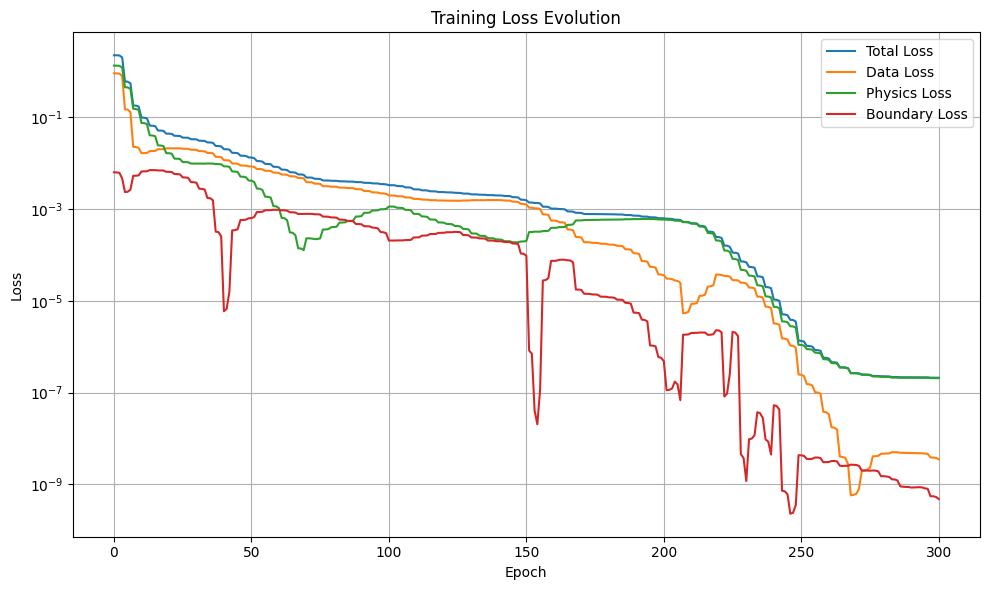

LBFGS iter:   300 | Loss: 2.0999e-07 | G_real = 0.18021 | G_PINN = 0.18933
Tiempo total de entrenamiento con optimizador ADAM 5.777302980422974


In [ ]:
# === Inicialización del modelo y optimizadores ===
G_init = 1
model_lbfgs = PINN_finn(layers=layers_finn, activation_fn=activation_fn, G_init=G_init)
print('Training LBFGS')
start_time = time.time()

# Separar parámetros de red y lambdas (CORREGIDO: incluir lambda_bc)
params_model_lbfgs = list(model_lbfgs.parameters())

# === Inicialización del optimizador LBFGS ===
optimizer_lbfgs = torch.optim.LBFGS(
    params_model_lbfgs,  # incluye tanto los pesos como G
    lr=learning_rate_LBFGS,
    max_iter=n_iter_LBFGS,
    max_eval=None,
    tolerance_grad=1e-11,
    tolerance_change=1e-11,
    line_search_fn='strong_wolfe',
    history_size=100
)

# === Closure para LBFGS ===
def closure():
    optimizer_lbfgs.zero_grad()

    loss_total = model_lbfgs.loss(
        X_real, Theta_real,
        X_train_f, X_bc,
        save=True
    )

    loss_total.backward()

    if model_lbfgs.iter % 50 == 0:
        clear_output(wait=True)
        plot_loss_history(model_lbfgs)
        print(
            f"LBFGS iter: {model_lbfgs.iter:5d} | Loss: {loss_total.item():.4e} | G_real = {G_real.item():.5f} | G_PINN = {model_lbfgs.G.item():.5f}"
        )

    model_lbfgs.iter += 1
    return loss_total

# === Ejecución del paso de optimización ===
print("Entrenando con LBFGS...")
optimizer_lbfgs.step(closure)
# Consumed time
elapsed_time_LBFGS = time.time() - start_time
print('Tiempo total de entrenamiento con optimizador ADAM', elapsed_time_LBFGS)

## Valido predicción con datos de prueba

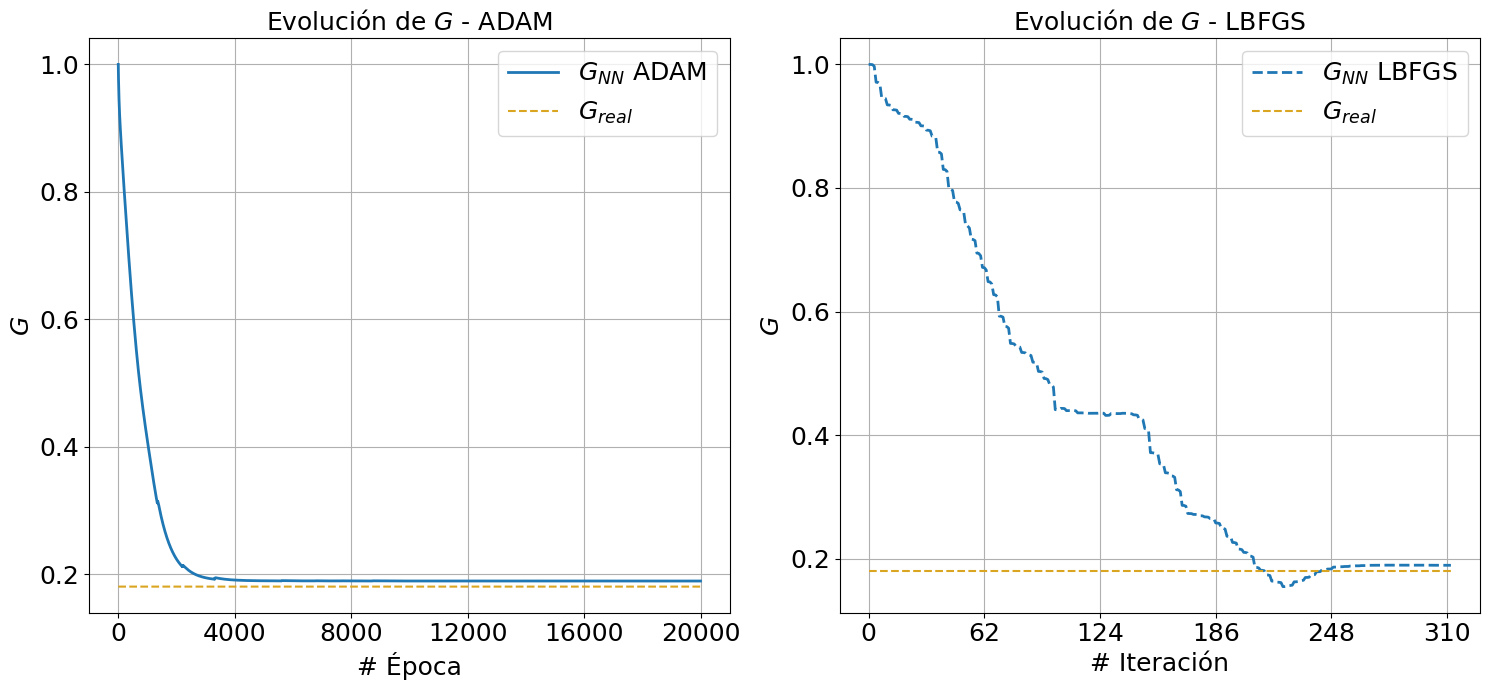

In [ ]:
label_size = 10
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# === ADAM ===
G_adam = np.array(model_adam.params_history["G"]).flatten()
nsteps_adam = len(G_adam)

ax[0].plot(G_adam, label=r'$G_{NN}$ ADAM', linewidth=2)
ax[0].plot(range(nsteps_adam), G_real.item() * np.ones(nsteps_adam), label=r'$G_{real}$', color='goldenrod', linestyle='--')
ax[0].set_xlabel('# Época', fontsize=1.8*label_size)
ax[0].set_ylabel(r'$G$', fontsize=1.8*label_size)
ax[0].grid(True, which="both", ls="-")
ax[0].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[0].legend(loc='upper right', fontsize=1.8*label_size)
ax[0].set_title('Evolución de $G$ - ADAM', fontsize=1.8*label_size)
ax[0].set_xticks(np.arange(0, nsteps_adam+1, max(1, nsteps_adam // 5)))

# === LBFGS ===
G_lbfgs = np.array(model_lbfgs.params_history["G"]).flatten()
nsteps_lbfgs = len(G_lbfgs)

ax[1].plot(G_lbfgs, label=r'$G_{NN}$ LBFGS', linestyle='--', linewidth=2)
ax[1].plot(range(nsteps_lbfgs), G_real.item() * np.ones(nsteps_lbfgs), label=r'$G_{real}$', color='goldenrod', linestyle='--')
ax[1].set_xlabel('# Iteración', fontsize=1.8*label_size)
ax[1].set_ylabel(r'$G$', fontsize=1.8*label_size)
ax[1].grid(True, which="both", ls="-")
ax[1].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[1].legend(loc='upper right', fontsize=1.8*label_size)
ax[1].set_title('Evolución de $G$ - LBFGS', fontsize=1.8*label_size)
ax[1].set_xticks(np.arange(0, nsteps_lbfgs+1, max(1, nsteps_lbfgs // 5)))

plt.tight_layout()
plt.show()

MSE ADAM   : 1.8027e-02
MAE ADAM   : 1.1966e-01
MSE LBFGS  : 1.8013e-02
MAE LBFGS  : 1.1961e-01


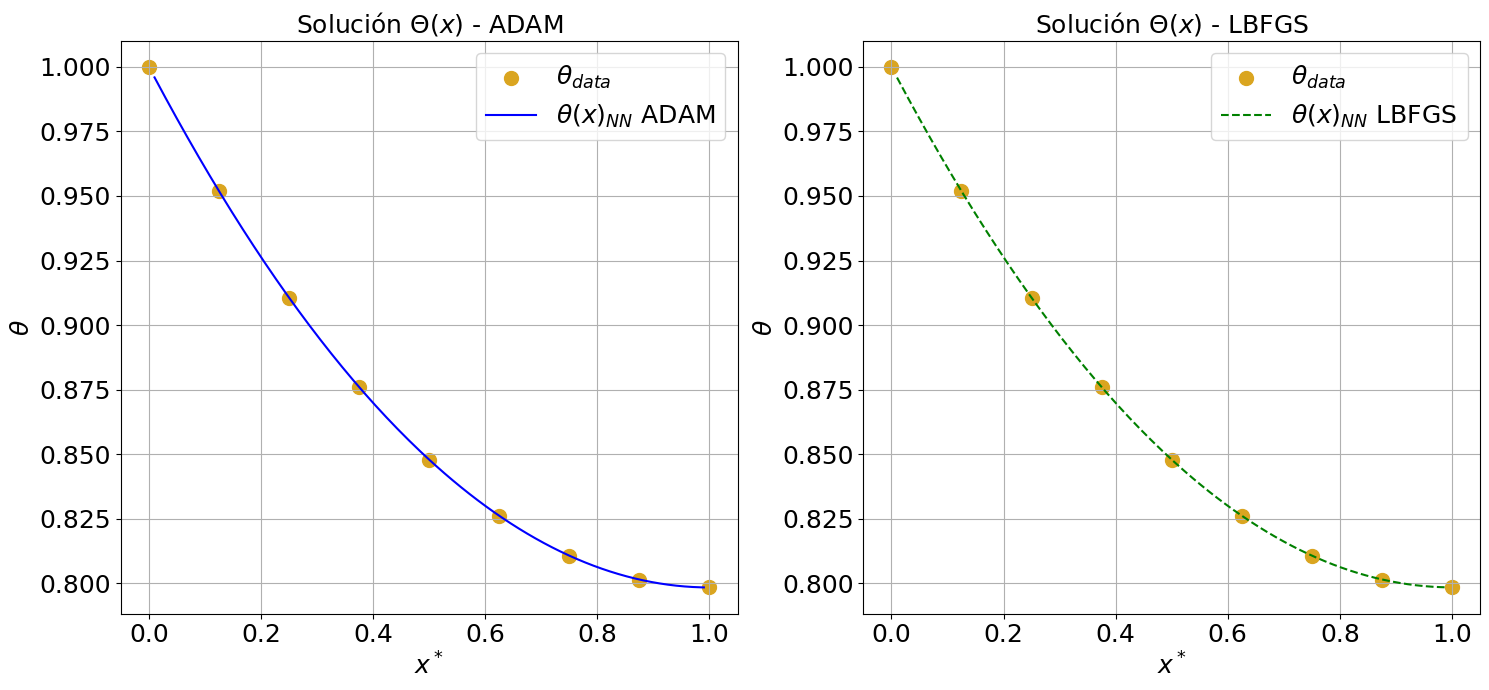

In [ ]:
# === Extraer datos necesarios ===
x_u = X_real.to('cpu').detach().numpy()
theta_real = Theta_real.to('cpu').detach().numpy()

x_f = X_train_f.to('cpu').detach().numpy()
theta_nn_adam = model_adam(X_train_f).to('cpu').detach().numpy()
theta_nn_lbfgs = model_lbfgs(X_train_f).to('cpu').detach().numpy()

theta_real_flat = theta_real.reshape(-1)
theta_pred_adam_flat = theta_nn_adam[:len(theta_real)].reshape(-1)
theta_pred_lbfgs_flat = theta_nn_lbfgs[:len(theta_real)].reshape(-1)

# Calcular errores
mse_adam = np.mean((theta_pred_adam_flat - theta_real_flat)**2)
mae_adam = np.mean(np.abs(theta_pred_adam_flat - theta_real_flat))

mse_lbfgs = np.mean((theta_pred_lbfgs_flat - theta_real_flat)**2)
mae_lbfgs = np.mean(np.abs(theta_pred_lbfgs_flat - theta_real_flat))

# Imprimir resultados
print(f"MSE ADAM   : {mse_adam:.4e}")
print(f"MAE ADAM   : {mae_adam:.4e}")
print(f"MSE LBFGS  : {mse_lbfgs:.4e}")
print(f"MAE LBFGS  : {mae_lbfgs:.4e}")

# === Crear gráfico comparativo ===
label_size = 10
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# --- ADAM ---
ax[0].scatter(x_u, theta_real, color='goldenrod', label=r'$\theta_{data}$', s=100)
ax[0].plot(x_f, theta_nn_adam, label=r'$\theta(x)_{NN}$ ADAM', color='blue')
ax[0].set_xlabel(r'$x^*$', fontsize=1.8*label_size)
ax[0].set_ylabel(r'$\theta$', fontsize=1.8*label_size)
ax[0].grid(True, which="both", ls="-")
ax[0].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[0].legend(loc='best', fontsize=1.8*label_size)
ax[0].set_title('Solución $\Theta(x)$ - ADAM', fontsize=1.8*label_size)

# --- LBFGS ---
ax[1].scatter(x_u, theta_real, color='goldenrod', label=r'$\theta_{data}$', s=100)
ax[1].plot(x_f, theta_nn_lbfgs, label=r'$\theta(x)_{NN}$ LBFGS', linestyle='--', color='green')
ax[1].set_xlabel(r'$x^*$', fontsize=1.8*label_size)
ax[1].set_ylabel(r'$\theta$', fontsize=1.8*label_size)
ax[1].grid(True, which="both", ls="-")
ax[1].tick_params(axis='both', which='major', labelsize=1.8*label_size)
ax[1].legend(loc='best', fontsize=1.8*label_size)
ax[1].set_title('Solución $\Theta(x)$ - LBFGS', fontsize=1.8*label_size)

plt.tight_layout()
plt.show()
